In [1]:
from dask.distributed import LocalCluster,Client
import stackstac
import dask.array as da
import pystac_client
import geopandas as gpd
import planetary_computer as pc
import xarray as xr

import os

from PIL import Image, ImageDraw, ImageFont
from xarray.plot.utils import _rescale_imshow_rgb
import numpy as np
from typing import TYPE_CHECKING, BinaryIO, cast,Literal
import ntpath

from IPython.display import HTML, display
import folium
import folium.plugins
from branca.element import Figure
import shapely.geometry

#### For Planetay datasets that require an API Key
- To use your API key locally, set the environment variable PC_SDK_SUBSCRIPTION_KEY or use ```planetary_computer.settings.set_subscription_key(<YOUR API Key>)```
- Your API key is available at https://planetarycomputer.developer.azure-api.net/profile

In [2]:
pc.settings.set_subscription_key('5f76969537404818891dee8872288a72')

In [3]:
# port forwarding : ssh -L 8000:localhost:8787 protect
# ou
# ssh -L 9998:129.88.193.194:22 ssh-ige
# ssh -L 9999:localhost:8787 -N -p 9998 localhost
# opne localhost:9999

cluster = LocalCluster(n_workers=5,
                       threads_per_worker=2,
                       dashboard_address=8787,
                       memory_limit='4GB')

client = Client(cluster)
#display(client)

/home/barreje/miniconda3/envs/earthgif/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33479 instead
  warnings.warn(


In [4]:
from dask.utils import ensure_dict, format_bytes
    
wk = client.scheduler_info()["workers"]

text="Workers= " + str(len(wk))
memory = [w["memory_limit"] for w in wk.values()]
cores = sum(w["nthreads"] for w in wk.values())
text += ", Cores=" + str(cores)
if all(memory):
    text += ", Memory=" + format_bytes(sum(memory))
print(text)

Workers= 5, Cores=10, Memory=18.63 GiB


In [5]:
# Define general variables

setting = {'spatial_resolution' : 100,
            'cloud_cover': 1}

glacier = "argentiere"
full_name= "Argentiere"

In [6]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [7]:
#petermann - or create one with https://geojson.io/#map=2/20.0/0.0 and follow https://aws.amazon.com/fr/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/

#filename = "geojson file path"
filename = glacier +".geojson"
# read in AOI as a GeoDataFrame
aoi = gpd.read_file(filename)

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    aoi['geometry'],
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)


map1.fit_bounds(bounds=convert_bounds(aoi.unary_union.bounds))
display(fig)

In [47]:
# see : https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/landsat-8-c2-l2/landsat-8-c2-l2-example.ipynb

bbox =aoi.unary_union.bounds

ImSatSTAC = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

#for collection in LandsatSTAC.get_collections():
    #print(collection)

search = (
    ImSatSTAC
    .search(
        bbox=bbox,
        datetime = "2021-01-01/2021-12-30", 
        collections = ["sentinel-1-rtc"],
        #query={"sat:orbit_state": dict(eq="descending")}
               
    )
)
items = pc.sign(search)
print(str(len(items))+ ' scenes found')

166 scenes found


Turn STAC items into xarray as a temporal stack, using stackstac.

In [73]:
stack = stackstac.stack(items, bounds_latlon=bbox, epsg = 3124,resolution=10)
stack.coords

Coordinates:
  * time                                   (time) datetime64[ns] 2021-01-01T1...
    id                                     (time) <U66 'S1B_IW_GRDH_1SDV_2021...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 -4.188e+06 ... -4.183e+06
  * y                                      (y) float64 1.256e+07 ... 1.256e+07
    start_datetime                         (time) <U32 '2021-01-01 17:22:45.2...
    sat:relative_orbit                     (time) int64 88 139 66 ... 139 66 88
    sat:absolute_orbit                     (time) int64 24964 25015 ... 41110
    sar:frequency_band                     <U1 'C'
    sar:looks_azimuth                      int64 1
    s1:datatake_id                         (time) <U6 '194718' ... '320095'
    s1:product_timeliness                  (time) <U8 'Fast-24h' ... 'NRT-3h'
    sar:pixel_spacing_range                int64 10
    sar:looks_range                        int64 5
   

In [71]:
stack.sel(band='vh')

<xarray.DataArray 'stackstac-da07e6755af1d73212774ea5ebda1ea9' (time: 166,
                                                                y: 562, x: 557)>
dask.array<getitem, shape=(166, 562, 557), dtype=float64, chunksize=(1, 562, 557), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2021-01-01T1...
    id                                     (time) <U66 'S1B_IW_GRDH_1SDV_2021...
    band                                   <U2 'vh'
  * x                                      (x) float64 -4.188e+06 ... -4.183e+06
  * y                                      (y) float64 1.256e+07 ... 1.256e+07
    start_datetime                         (time) <U32 '2021-01-01 17:22:45.2...
    ...                                     ...
    end_datetime                           (time) <U32 '2021-01-01 17:23:10.2...
    sar:observation_direction              <U5 'right'
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VH: vertical transmit, horiz...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 3124
Attributes:
    spec:        RasterSpec(epsg=3124, bounds=(-4188280, 12558200, -4182710, ...
    crs:         epsg:3124
    transform:   | 10.00, 0.00,-4188280.00|\n| 0.00,-10.00, 12563820.00|\n| 0...
    resolution:  10

In [62]:

satDescending= stack[stack["sat:orbit_state"].values=='descending']
satDescending.shape

(56, 2, 562, 557)

In [19]:
vv = stack.sel(band="vv")[0].compute()
#vv.plot.hist(bins=30);

In [20]:
vv

<xarray.DataArray 'stackstac-8e98de344581e8119f6fe2c664d77e01' (y: 562, x: 557)>
array([[0.01380156, 0.00861691, 0.00861691, ..., 0.19585131, 0.21757102,
        0.19369696],
       [0.01380156, 0.01506203, 0.02017421, ..., 0.12813169, 0.21757102,
        0.18027022],
       [0.01029741, 0.01506203, 0.02253141, ..., 0.16325973, 0.16325973,
        0.14092772],
       ...,
       [0.03359991, 0.02857024, 0.02254693, ..., 0.15982315, 0.12701085,
        0.10562749],
       [0.03868325, 0.0308912 , 0.02664318, ..., 0.15982315, 0.13003564,
        0.10562749],
       [0.03868325, 0.0454991 , 0.02222552, ..., 0.24766539, 0.13003564,
        0.12419838]])
Coordinates: (12/39)
    time                                   datetime64[ns] 2021-01-01T17:22:57...
    id                                     <U66 'S1B_IW_GRDH_1SDV_20210101T17...
    band                                   <U2 'vv'
  * x                                      (x) float64 -4.188e+06 ... -4.183e+06
  * y                                      (y) float64 1.256e+07 ... 1.256e+07
    start_datetime                         <U32 '2021-01-01 17:22:45.250024+0...
    ...                                     ...
    end_datetime                           <U32 '2021-01-01 17:23:10.248545+0...
    sar:observation_direction              <U5 'right'
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 3124
Attributes:
    spec:        RasterSpec(epsg=3124, bounds=(-4188280, 12558200, -4182710, ...
    crs:         epsg:3124
    transform:   | 10.00, 0.00,-4188280.00|\n| 0.00,-10.00, 12563820.00|\n| 0...
    resolution:  10

In [115]:
# as said here (https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook) values need to be rescaled to be visualized.

def db_scale(x):
    return 10 * np.log10(x)

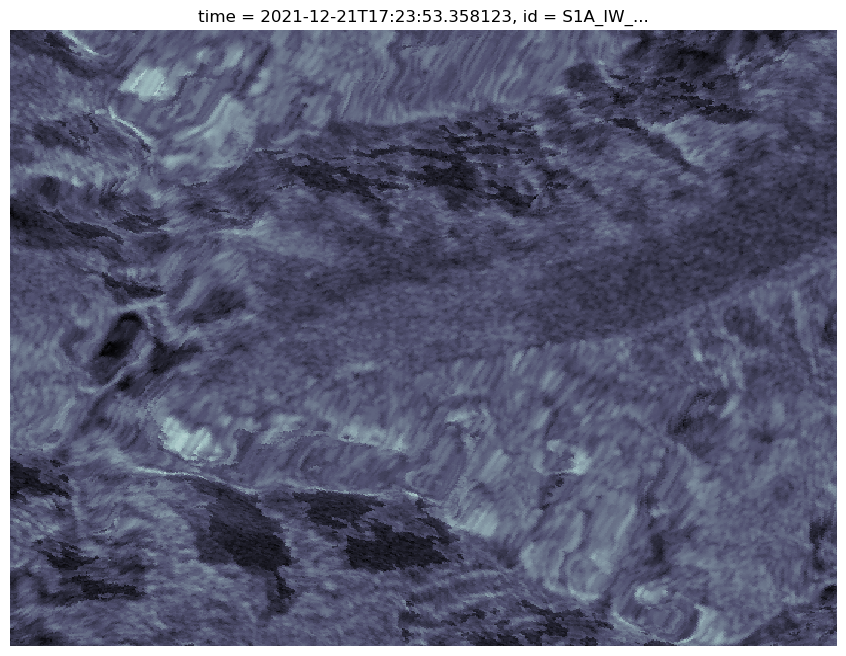

In [125]:
img = (
    db_scale(vv)
    .coarsen(x=1, y=1, boundary="trim")
    .max()
    .plot.imshow(cmap="bone", size=8,  add_colorbar=False)
)
img.axes.set_axis_off();

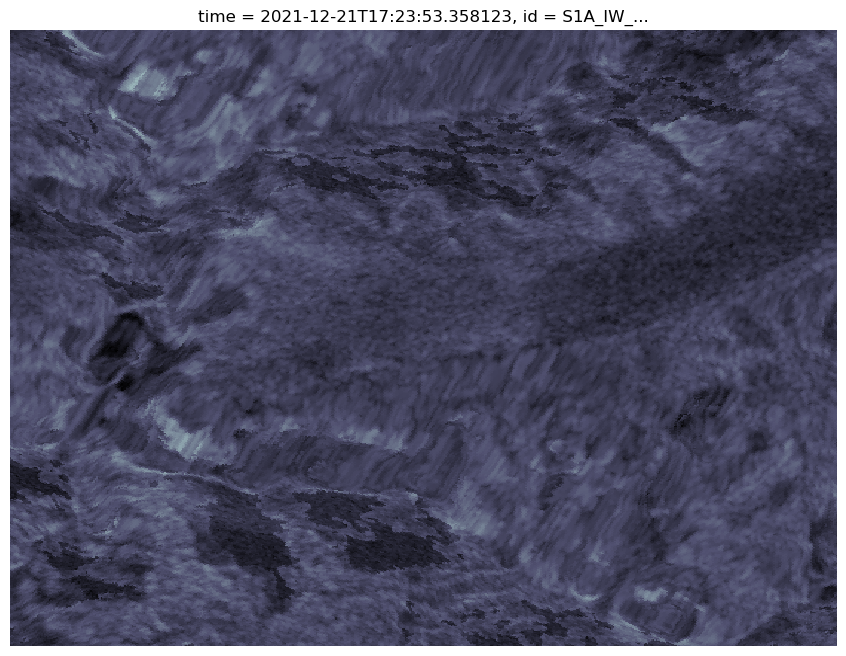

In [124]:
vh = stack.sel(band="vh")[0].compute()
img = (
    db_scale(vh)
    .coarsen(x=1, y=1, boundary="trim")
    .max()
    .plot.imshow(cmap="bone", size=8, add_colorbar=False)
)
img.axes.set_axis_off();